<div>
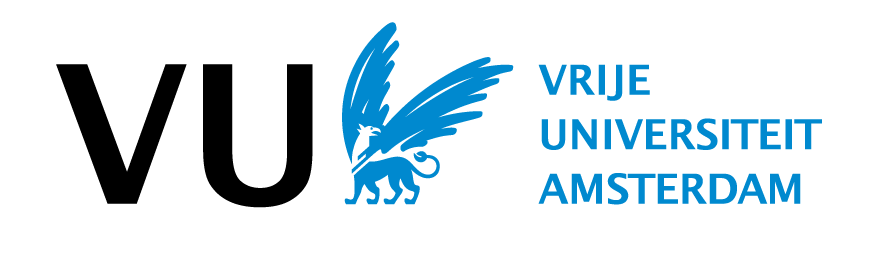
</div>


### Gridap day at "Groupe Calcul"

# Solving nonlinear PDEs with Gridap


by Francesc Verdugo (VU Amsterdam)

2022-12-01

## Contents

- Solve a nonlinear PDE with Gridap
- In serial and in parallel
- AD in Gridap

## Example

- 3D p-Laplacian equation
- Two different Dirichlet boundary conditions


$$
\left\lbrace
\begin{aligned}
-\nabla \cdot \left( |\nabla u|^{p-2} \ \nabla u \right) = f\ &\text{in}\ \Omega,\\
u = 0 \ &\text{on} \ \Gamma_0,\\
u = g \ &\text{on} \ \Gamma_g,\\
\left( |\nabla u|^{p-2}\ \nabla u \right)\cdot n = 0 \ &\text{on} \ \Gamma_{\rm N},
\end{aligned}
\right.
$$

- $\Gamma_0$ is the green boundary
- $\Gamma_g$ is the blue boundary



<div>
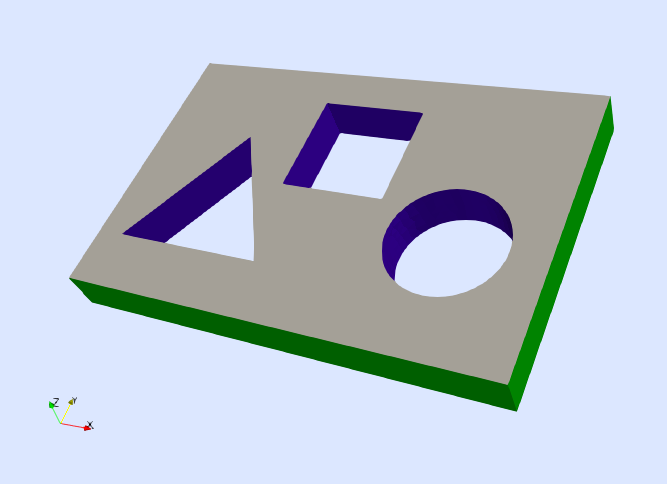
</div>


## Numerical scheme

We consider a standard FEM.

Find $u\in U_h$ such that $ r(u,v) = 0 $ for all $v\in V_h$


$$
r(u,v) \doteq \int_\Omega \nabla v \cdot \left( |\nabla u|^{p-2}\ \nabla u \right) \ {\rm d}\Omega - \int_\Omega v\ f \ {\rm d}\Omega.
$$


## Read a mesh from Gmsh

In [ ]:
using Gridap
using GridapGmsh

In [ ]:
msh_file = joinpath(@__DIR__,"toy_model.msh")
model = GmshDiscreteModel(msh_file)

## Computational domain

In [ ]:
Ω = Interior(model,tags="volume")

## FE space

In [ ]:
k = 1
reffe = ReferenceFE(lagrangian,Float64,k)
tags = ["sides","circle","triangle", "square"]
Vh = TestFESpace(Ω,reffe,dirichlet_tags=tags)

In [ ]:
g = 2
Uh = TrialFESpace(Vh,[0,g,g,g])

## Visualize FE space

In [ ]:
x = rand(num_free_dofs(Uh))
vh_rand = FEFunction(Vh,x)
x = copy(x)
uh_rand = FEFunction(Uh,x)
writevtk(Ω,"Ω",cellfields=["uh_rand"=>uh_rand,"vh_rand"=>vh_rand])

## Weak form

$$
r(u,v) \doteq \int_\Omega \nabla v \cdot \left( |\nabla u|^{p-2}\ \nabla u \right) \ {\rm d}\Omega - \int_\Omega v\ f \ {\rm d}\Omega.
$$


In [ ]:
f = 1
dΩ = Measure(Ω,2*k)
const p = 3
α(∇u) = norm(∇u)^(p-2)
r(u,v) = ∫( ∇(v)⋅((α∘(∇(u)))*∇(u)) - v*f )*dΩ

## Nonlinear FE problem

In [ ]:
op = FEOperator(r,Uh,Vh)

In [ ]:
solver = NLSolver(show_trace=true, method=:newton, iterations=30)

In [ ]:
uh = solve(solver,op)

NOTE: The Jacobian matrix is singular for a zero initial guess in this example.

$$
r(u,v) \doteq \int_\Omega \nabla v \cdot \left( |\nabla u|^{p-2}\ \nabla u \right) \ {\rm d}\Omega - \int_\Omega v\ f \ {\rm d}\Omega.
$$

In [ ]:
x = zeros(num_free_dofs(Uh))
zh = FEFunction(Uh,x)
writevtk(Ω,"Ω",cellfields=["α∇zh"=>α∘(∇(zh)),"uh_rand"=>uh_rand,"vh_rand"=>vh_rand])

## Non-zero initial guess

In [ ]:
x = rand(num_free_dofs(Uh))
uh = FEFunction(Uh,x)

In [ ]:
uh, cache = solve!(uh,solver,op)

In [ ]:
uh, cache = solve!(uh,solver,op,cache)

In [ ]:
writevtk(Ω,"Ω",cellfields=["uh"=>uh,"α∇zh"=>α∘(∇(zh)),"uh_rand"=>uh_rand,"vh_rand"=>vh_rand])

<div>
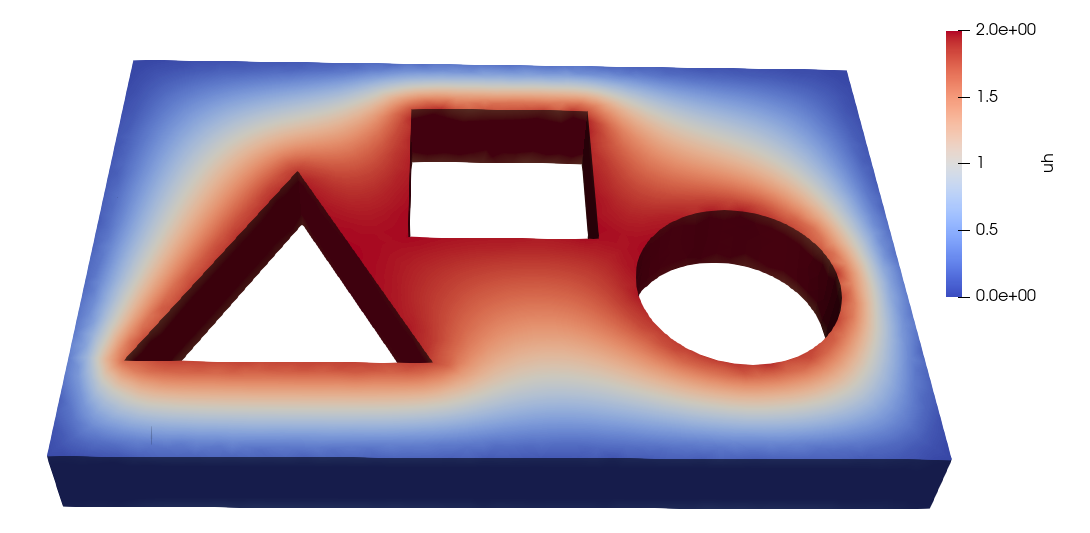
</div>

## Defining the Jacobian manually

Gridap requires the weak Jacobian in a given direction $\delta u$

$$J(u,\delta u, v) = \dfrac{d}{d \epsilon}|_{\epsilon = 0} r(u+\epsilon \delta u, v) $$



In [ ]:
J(u,du,v) = ∫( ∇(v)⋅((dα∘(∇(u),∇(du)))*∇(u) + (α∘(∇(u)))*∇(du)) )*dΩ

In [ ]:
dα(∇u,∇du) = (p-2)*norm(∇u)^(p-4)*∇u⋅∇du

In [ ]:
op = FEOperator(r,J,Uh,Vh)

In [ ]:
x = rand(num_free_dofs(Uh))
uh = FEFunction(Uh,x)
uh, cache = solve!(uh,solver,op);

## Automatic Differentiation

ForwardDiff can be used to compute the Jacobian matrix for functions $f: \mathbb{R}^m\longrightarrow \mathbb{R}^n$

In [ ]:
using ForwardDiff

In [ ]:
func(x) = [x[1]^2, 4*x[2]]

In [ ]:
ForwardDiff.jacobian(func,[3.4,4.1])

## Global FE residual

In [ ]:
function func(x)
    uh = FEFunction(Uh,x)
    l(v) = r(uh,v)
    assemble_vector(l,Vh)
end

In [ ]:
x = rand(num_free_dofs(Uh))
func(x)

In [ ]:
## Do not run this
# (it will return a large dense matrix)
#
# ForwardDiff.jacobian(func,x)

## Cell-wise AD Jacobian

We use ForwardDiff to compute the local Jacobian at each cell, and we assembly a sparse matrix from them.

### Cell-wise residual from FE function

In [ ]:
function func(uh)
    dv = get_fe_basis(Vh)
    r(uh,dv)
end

In [ ]:
contrib = func(uh)

In [ ]:
cell = 1000
contrib[Ω][cell]

### Cell-wise AD Jacobian

In [ ]:
contrib = Gridap.jacobian(func,uh)

In [ ]:
cell = 1000
contrib[Ω][cell]

## Cell-wise residual and Jacobian from energy

$$r(u,v) = \dfrac{d}{d \epsilon}|_{\epsilon = 0} e(u+\epsilon v) $$

with

$$
  e(u) \doteq \dfrac{1}{p}\int_{\Omega} |\nabla u|^p  {\rm d}\Omega - \int_{\Omega} u\ f  \ {\rm  d}\Omega 
$$





In [ ]:
β(∇u) = norm(∇u)^p
e(u) = (1/p)*(∫( β∘(∇(u)) )*dΩ) - ∫(u*f)*dΩ

### Cell-wise energy from FE function

In [ ]:
contrib = e(uh)

In [ ]:
cell = 1000
contrib[Ω][cell]

### Cell-wise AD residual

In [ ]:
contrib = Gridap.gradient(e,uh)

In [ ]:
cell = 1000
contrib[Ω][cell]

In [ ]:
dv = get_fe_basis(Vh)
r(uh,dv)[Ω][cell]

### Cell-wise AD Jacobian

In [ ]:
contrib = Gridap.hessian(e,uh)

In [ ]:
cell = 1000
contrib[Ω][cell]

In [ ]:
du = get_trial_fe_basis(Uh)
J(uh,du,dv)[Ω][cell]

## FE problem from energy definition only

In [ ]:
r_from_e(u,v) = Gridap.gradient(e,u)
J_from_e(u,du,v) = Gridap.hessian(e,u)

In [ ]:
op = FEOperator(r_from_e,J_from_e,Uh,Vh)

In [ ]:
x = rand(num_free_dofs(Uh))
uh = FEFunction(Uh,x)
uh, cache = solve!(uh,solver,op);

# Parallel version

In [ ]:
using GridapDistributed
using PartitionedArrays

In [ ]:
backend = SequentialBackend()
nparts = 4
parts = get_part_ids(backend,nparts)

In [ ]:
msh_file = joinpath(@__DIR__,"toy_model.msh")
model = GmshDiscreteModel(parts,msh_file)

In [ ]:
Ω = Interior(model,tags="volume")

In [ ]:
k = 1
reffe = ReferenceFE(lagrangian,Float64,k)
tags = ["sides","circle","triangle", "square"]
Vh = TestFESpace(Ω,reffe,dirichlet_tags=tags)

In [ ]:
g = 2
Uh = TrialFESpace(Vh,[0,g,g,g])

In [ ]:
dΩ = Measure(Ω,2*k)
r(u,v) = ∫( ∇(v)⋅((α∘(∇(u)))*∇(u)) - v*f )*dΩ
J(u,du,v) = ∫( ∇(v)⋅((dα∘(∇(u),∇(du)))*∇(u) + (α∘(∇(u)))*∇(du)) )*dΩ

In [ ]:
op = FEOperator(r,J,Uh,Vh)

## Parallel random initial guess

In [ ]:
ids = get_free_dof_ids(Uh)
x = PVector{Float64}(undef,ids)
map_parts(x.values) do values
    values .= rand(length(values))
end
x

## PETSc nonlinear solver

In [ ]:
using GridapPETSc

In [ ]:
options = "-snes_type newtonls -snes_rtol 1.0e-14 -snes_atol 0.0 -snes_monitor -pc_type jacobi -ksp_type gmres -snes_converged_reason -ksp_converged_reason -ksp_error_if_not_converged true"

In [ ]:
uh = GridapPETSc.with(args=split(options)) do
    solver = PETScNonlinearSolver()
    uh = FEFunction(Uh,x)
    uh,cache = solve!(uh,solver,op)
    uh
end

In [ ]:
writevtk(Ω,"Ω",cellfields=["uh"=>uh]);